In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#!pip install tensorflow
#!pip install tensorflow_federated

In [ ]:
# 1. Import libraries
import os
import glob
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.preprocessing import MinMaxScaler
#from scipy.stats import ttest_rel
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.metrics import RootMeanSquaredError
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import date
import time

In [4]:
# 2.Constants
N_INPUT = 72 # or 168 -- now 3 days look-back considered
N_OUTPUT = 24
stride = 1
BATCH_SIZE = 32
EPOCHS = 5
ONE_YEAR_HOURS = 24 * 365
num_features = 2          # 'kwh', 'm3h'
DATA_DIR = "/content/drive/MyDrive/thesis_timeseries/data"  # Path to .pkl files


# client files
client_files = [os.path.join(DATA_DIR, "695645.pkl"), os.path.join(DATA_DIR, "695947.pkl"), os.path.join(DATA_DIR, "696204.pkl")]
client_ids = ['Client 1', 'Client 2', 'Client 3']


# Load and scale
def load_and_split(file_path, train_ratio, val_ratio, client_name):
    df = pd.read_pickle(file_path)
    if len(df) > ONE_YEAR_HOURS:
        df = df[-ONE_YEAR_HOURS:]
    df = df[['kwh', 'm3h']].astype(np.float32)
    print(f"{client_name} Total data: ", df.shape)

    # Split
    total = len(df)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)

    train, val, test = df[:train_end], df[train_end:val_end], df[val_end:]

    # Split into inputs (X) and outputs (y)
    full_scaler = MinMaxScaler()
    train_scaled = full_scaler.fit_transform(train)
    val_scaled = full_scaler.transform(val)
    test_scaled = full_scaler.transform(test)


    # Separate scaler for the target: kwh
    target_scaler = MinMaxScaler()
    target_scaler.fit(train[['kwh']])  # Only fit on target


    return train_scaled, val_scaled, test_scaled, full_scaler, target_scaler

# Inverse tranform
def inverse_transform_sequence(scaler, data):
    return scaler.inverse_transform(data.reshape(-1, 1)).reshape(data.shape)


# Create sequences
def create_multistep_sequences(data, n_input, n_output, stride=1):
    X, y = [], []
    for i in range(0, len(data) - n_input - n_output + 1, stride):
        X.append(data[i:i + n_input, 0:2]) # inputs: kwh and m3h
        y.append(data[i + n_input:i + n_input + n_output, 0])  # Predict: kwh

    X = np.array(X)  # shape: (samples, n_input, n_features)
    y = np.array(y)  # shape: (samples, n_output)
    return X, y



In [5]:
# Create tff.data.Dataset - Prepare TFF Client Datasets
def create_tff_dataset(file_path, client_name):
    # Load and split
    train_ratio=0.6
    val_ratio=0.2
    # Loads and scales only the training data from a client’s .pkl file.
    train_scaled, _, _, _, _= load_and_split(file_path, train_ratio, val_ratio, client_name)

    # Converts the training time series into sliding window sequences (e.g., past 168 hours → next 24 hours).
    X, y = create_multistep_sequences(train_scaled, N_INPUT, N_OUTPUT)

  # Wraps the (X, y) arrays into a tf.data.Dataset object, which is the format TensorFlow Federated expects.
    ds = tf.data.Dataset.from_tensor_slices((X, y))

    #  .batch(BATCH_SIZE): Batches data into mini-batches andprefetch(...): Optimizes input pipeline performance.
    return ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
client_datasets = {
    cid: create_tff_dataset(fp, cid) for cid, fp in zip(client_ids, client_files)
}

Client 1 Total data:  (8760, 2)
Client 2 Total data:  (8760, 2)
Client 3 Total data:  (8760, 2)


In [7]:
# n_input = SEQ_Length

# Define LSTM Model
def build_lstm_model(n_input, n_features, n_output):

    model = tf.keras.Sequential([
        # Input layer
        tf.keras.Input(shape=(n_input, n_features)),

        tf.keras.layers.LSTM(16, return_sequences=False), # removed recurrent_dropout, reduced units to 16

        # Fully connected layer
        tf.keras.layers.Dense(16, activation='relu'), # reduced units to 16
        # Drop out
        tf.keras.layers.Dropout(0.05),
        # Output layer
        tf.keras.layers.Dense(n_output) # output from model = (samples, 24)
    ])
    # Configuration of Keras Model for training purpose
    #model.summary()
    return model


In [8]:
# model_fn() for TFF - Wrap Keras Model for TFF
def model_fn():

    keras_model = build_lstm_model(N_INPUT, num_features, N_OUTPUT)

    # Dummy batch to define input_spec
    dummy_batch = create_tff_dataset(client_files[0], client_ids[0]).take(1)
    input_spec = dummy_batch.element_spec

    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae"),
                 tf.keras.metrics.RootMeanSquaredError(name="rmse")]
    )

In [9]:
# Build Federated Training Process
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.02),
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0)
)

Client 1 Total data:  (8760, 2)
Client 1 Total data:  (8760, 2)
Client 1 Total data:  (8760, 2)


In [10]:
# Simulate Federated Training

# Initialize
state = iterative_process.initialize()

# Training rounds
NUM_ROUNDS = 5
# Track history
federated_mae_history = []
client_local_mae_history = {cid: [] for cid in client_ids}

# Training loop
for round_num in range(1, NUM_ROUNDS + 1):
    # Federated step and Track exectuion time for each round
    round_start_time = time.time()

    # 1. FL training
    selected_data = [client_datasets[cid] for cid in client_ids]
    state, metrics = iterative_process.next(state, selected_data)
    round_time = time.time() - round_start_time
    print(f'Round {round_num}, Metrics: {metrics}, Time: {round_time:.2f} seconds')

    # 2: Evaluate FL model on test data
    fl_model = build_lstm_model(N_INPUT, num_features, N_OUTPUT)
    #state.model.assign_weights_to(fl_model)
    state.global_model_weights.assign_weights_to(fl_model)

    fl_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    fl_maes = []
    for cid, path in zip(client_ids, client_files):
        _, _, test_scaled, _, target_scaler = load_and_split(path, train_ratio=0.6, val_ratio=0.2, client_name=cid)
        X_test, y_test = create_multistep_sequences(test_scaled, N_INPUT, N_OUTPUT)

        y_pred = fl_model.predict(X_test)
        y_pred_inv = inverse_transform_sequence(target_scaler, y_pred)
        y_test_inv = inverse_transform_sequence(target_scaler, y_test)

        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        fl_maes.append(mae)

    fl_avg_mae = np.mean(fl_maes)
    federated_mae_history.append(fl_avg_mae)
    print(f"FL Model Avg MAE on Test Data: {fl_avg_mae:.4f}")

    # 3: Local models
    for cid, path in zip(client_ids, client_files):
        train_scaled, _, test_scaled, _, target_scaler = load_and_split(path, train_ratio=0.6, val_ratio=0.2, client_name=cid)
        X_train, y_train = create_multistep_sequences(train_scaled, N_INPUT, N_OUTPUT)
        X_test, y_test = create_multistep_sequences(test_scaled, N_INPUT, N_OUTPUT)

        local_model = build_lstm_model(N_INPUT, num_features, N_OUTPUT)
        local_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        local_model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose=0)

        y_pred_local = local_model.predict(X_test)
        y_pred_local_inv = inverse_transform_sequence(target_scaler, y_pred_local)
        y_test_inv = inverse_transform_sequence(target_scaler, y_test)

        mae_local = mean_absolute_error(y_test_inv, y_pred_local_inv)
        client_local_mae_history[cid].append(mae_local)

        print(f"{cid} Local Model MAE on Test Data: {mae_local:.4f}")


Round 1, Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mae', 0.09252378), ('rmse', 0.11790193), ('loss', 0.013900866), ('num_examples', 15483), ('num_batches', 486)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))]), Time: 13.56 seconds
Client 1 Total data:  (8760, 2)
52/52 [==============================] - 1s 6ms/step
Client 2 Total data:  (8760, 2)
52/52 [==============================] - 0s 6ms/step
Client 3 Total data:  (8760, 2)
52/52 [==============================] - 0s 6ms/step
FL Model Avg MAE on Test Data: 7.6672
Client 1 Total data:  (8760, 2)
52/52 [==============================] - 1s 6ms/step
Client 1 Local Model MAE on Test Data: 1.7327
Client 2 Total data:  (8760, 2)
52/52 [==============================] - 1s 6ms/step
Client 2 Local Model MAE on Test Data: 0.8691
Client 3 Total data:  (8760, 2)
52/52 [==============================] -

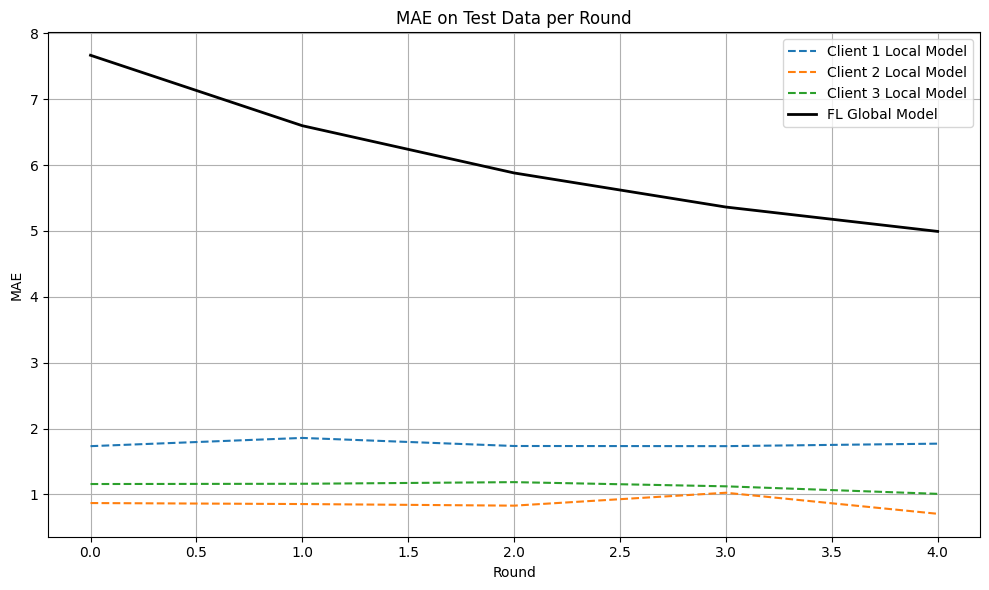

In [11]:
# Plot MAE per round
plt.figure(figsize=(10, 6))

# Local models
for cid in client_ids:
    plt.plot(client_local_mae_history[cid], label=f"{cid} Local Model", linestyle='--')

# FL model
plt.plot(federated_mae_history, label="FL Global Model", linewidth=2, color='black')

plt.title("MAE on Test Data per Round")
plt.xlabel("Round")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Reflection**:- using TFF and FedAvg
The above plot shows MAE (Mean Absolute Error) over training 5 rounds for both:
 1.  A global Federated Learning (FL) model trained collaboratively using data from all clients. Data from clients are not shared with FL model but weights are shared.
 2.  Local models trained independently on each client training data

1. FL Global model in black line - it starts with MAE approx 7.7 in round 1 and decreases to MAE 5 in round 5. It shows it is improving gradualy across the rounds and learning and generalizing better over the time by aggregating the weights from all three clients on unknown test data.

2. Local models in colored dashes lines - Local models are trained on their own local data. The MAE line for each client's local model is mostly flat and showing no improvements across the rounds and epochs used.

**Interpretation**:
* Global MAE shows FL model is learning from diverse data while Local MAE shows Local model learning from its own data. FL model could learn and generalize more over the time with more rounds.
* Federated training is effective because it is learning from diverse data still its model performance improves over the time and with each round.
* Feels like local models are simple and already have a predictive ability.



In [12]:
# Forecasting on test data

def forecast_and_plot(state, file_path, cid, n_input, n_output):
    _, _, test_scaled, scaler, target_scaler = load_and_split(file_path, train_ratio=0.6, val_ratio=0.2, client_name = cid)

    num_features = test_scaled.shape[1]

    X_test, y_test = create_multistep_sequences(test_scaled, n_input, n_output)

    # Load and prepare model
    model = build_lstm_model(n_input, num_features, n_output)
    state.global_model_weights.assign_weights_to(model)
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'rmse'])


# Predict test set
    pred_scaled = model.predict(X_test)
    predicted = inverse_transform_sequence(target_scaler, pred_scaled)
    actual = inverse_transform_sequence(target_scaler, y_test)

    mae = mean_absolute_error(actual[0], predicted[0])
    rmse = np.sqrt(mean_squared_error(actual[0], predicted[0]))
    print(f"Forecast on unknown Test data ---> MAE: {mae:.2f}, RMSE: {rmse:.2f}")


    # Plot last time step for Actual and Predicted values
    plt.plot(range(N_OUTPUT), actual[-1], label='Actual')
    plt.plot(range(N_OUTPUT), predicted[-1], label='Forecast', linestyle='--')
    plt.title(f"{cid} - 24-Hours Forecast")
    plt.xlabel("24 Hours Ahead")
    plt.ylabel("kwh")
    plt.legend()
    plt.show()

Client 1 Total data:  (8760, 2)
52/52 [==============================] - 2s 6ms/step
Forecast on unknown Test data ---> MAE: 0.59, RMSE: 0.73


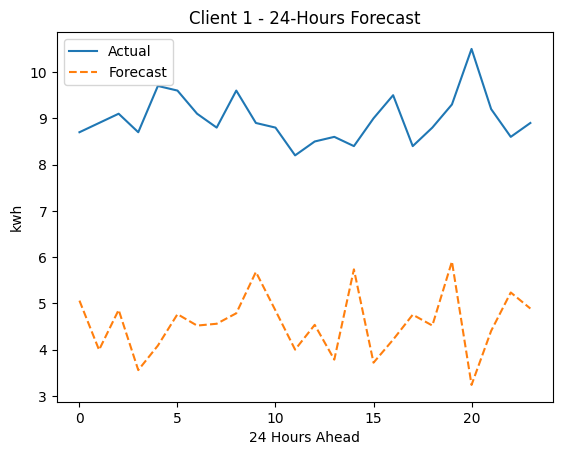

Client 2 Total data:  (8760, 2)
52/52 [==============================] - 1s 7ms/step
Forecast on unknown Test data ---> MAE: 1.52, RMSE: 1.62


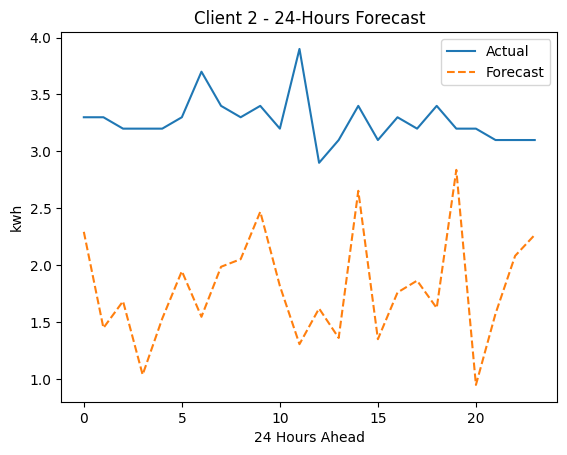

Client 3 Total data:  (8760, 2)
52/52 [==============================] - 1s 8ms/step
Forecast on unknown Test data ---> MAE: 7.24, RMSE: 7.33


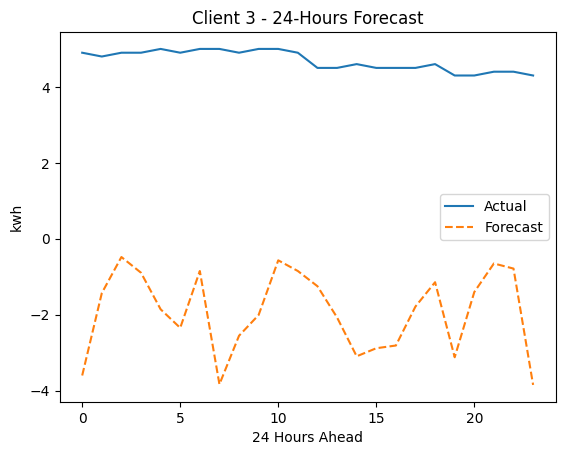

In [13]:
# Run Forecasting for All Clients
for cid, fp in zip(client_ids, client_files):
    forecast_and_plot(state, fp, cid, N_INPUT, N_OUTPUT)


**Reflection**: Forecasting

The above three plots shows forecasting of energy consumption (kwh) for three clients using last trained FL global model on unseen test data for next 24 hours.

Interepretation:
1. It shows high gap between actual and forecasted Kwh value. Forecasted values are lower than actual values, where it predicts lower energy demand than the real values.
2. There is a fluctuation in trend, sometimes it follow the shape and sometime it is reverse. So there is a biasness or undertraining is performed.
